In [1]:
!pip install torch
!pip install transformers

     |████████████████████████████████| 3.1 MB 5.1 MB/s 
     |████████████████████████████████| 895 kB 43.2 MB/s 
     |████████████████████████████████| 3.3 MB 41.3 MB/s 
     |████████████████████████████████| 596 kB 62.5 MB/s 
     |████████████████████████████████| 61 kB 382 kB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
%matplotlib inline
sns.set(color_codes=True)

In [3]:
import torch
import transformers
import random

SEED = 100

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [4]:
# import all the tools
import tensorflow as tf
import tensorflow.keras as keras
from wordcloud import WordCloud
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
sns.set_style('darkgrid')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [5]:
!pip install datasets

     |████████████████████████████████| 298 kB 5.0 MB/s 
     |████████████████████████████████| 243 kB 41.4 MB/s 
     |████████████████████████████████| 1.1 MB 44.8 MB/s 
     |████████████████████████████████| 132 kB 45.5 MB/s 
     |████████████████████████████████| 271 kB 47.7 MB/s 
     |████████████████████████████████| 192 kB 32.0 MB/s 
     |████████████████████████████████| 160 kB 59.3 MB/s 


In [6]:

from datasets import load_dataset
dataset = load_dataset(
   'sentiment140')

Downloading:   0%|          | 0.00/1.54k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/739 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/81.4M [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset sentiment140 downloaded and prepared to /root/.cache/huggingface/datasets/sentiment140/sentiment140/1.0.0/f81c014152931b776735658d8ae493b181927de002e706c4d5244ecb26376997. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [7]:
train = dataset["train"]
test = dataset["test"]

In [8]:
import pandas as pd

df_train = pd.DataFrame(list(zip(train['text'], train['sentiment'])), 
                        columns =['text', 'sentiment'])
df_test = pd.DataFrame(list(zip(test['text'], test['sentiment'])), 
                        columns =['text', 'sentiment'])

In [9]:
df_train.sentiment.value_counts()

4    800000
0    800000
Name: sentiment, dtype: int64

In [10]:
dataset = df_train.sample(n = 80000, random_state = SEED).reset_index(drop=True)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


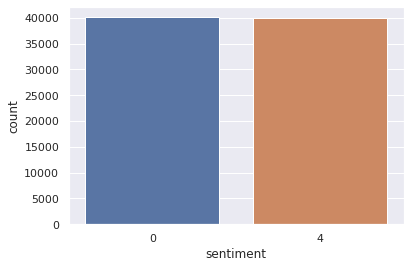

In [11]:
sns.countplot(dataset.sentiment)
plt.show()

In [12]:
#Checking Null values
dataset.isnull().sum()

text         0
sentiment    0
dtype: int64

In [13]:
#Replacing the target class '4' with '1'
dataset['sentiment'].replace({4: 1}, inplace=True)

In [14]:
import re
def text_preprocessing(text):
    """
    - Remove entity mentions (eg. '@united')
    - Correct errors (eg. '&amp;' to '&')
    @param    text (str): a string to be processed.
    @return   text (Str): the processed string.
    """
    text = text.lower()
    
    # Remove '@name'
    text = re.sub(r'(@.*?)[\s]', ' ', text)

    # Replace '&amp;' with '&'
    text = re.sub(r'&amp;', '&', text)

    # Remove trailing whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [15]:
print(dataset.text[0]) 
print(text_preprocessing(dataset.text[0]))

@nicholasmw 1 day u will find that girl worry 
1 day u will find that girl worry


## Data Preparation

In [16]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from nltk import TweetTokenizer

In [17]:
tweet_tokenizer= TweetTokenizer(reduce_len=3)
dataset.text = dataset.text.apply(lambda x: tweet_tokenizer.tokenize(x))

In [18]:
dataset.text[0]

['@nicholasmw', '1', 'day', 'u', 'will', 'find', 'that', 'girl', 'worry']

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


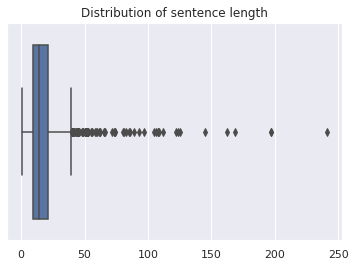

In [19]:
# See the distribution of sentence length 
sen_length = [len(x) for x in dataset.text.tolist()]
sns.boxplot(sen_length)
plt.title('Distribution of sentence length')
plt.show()

In [20]:
# based on the plot
MAX_LEN=40

In [21]:
# Function for build text list
def word_list(dataframe):
  df = dataframe.copy()
    
  # lemmatize the word
  lemma = nltk.WordNetLemmatizer()
  df = df.apply(lambda x: [lemma.lemmatize(i) for i in x])
    
  # combined into a sentence again
  df = df.apply(lambda x: ' '.join(x))

  word_list = df.tolist()
  return word_list

# Tokenize and padding the text list
def token_padding(word_list, tokenizer,length,pad):
  sequences = tokenizer.texts_to_sequences(word_list)
  padding = pad_sequences(sequences, maxlen=length,padding=pad,truncating='post')
  return padding

In [22]:
from sklearn.model_selection import train_test_split

# tokenize and padding
embedding_dim = 50 # since we will use 50d of Glove
max_length = 30
padding = 'post'
oov_tok = '<OOV>'
batch_size = 32

#splitting dataset into train, val, test sets
X = dataset.text
y = dataset.sentiment

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.38, random_state=SEED)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=SEED)

X_train_list = word_list(X_train)
X_val_list = word_list(X_val)

# make tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train_list)

X_train_pad = token_padding(X_train_list, tokenizer, max_length,padding)
X_val_pad = token_padding(X_val_list, tokenizer, max_length,padding)

train_set = tf.data.Dataset.from_tensor_slices((X_train_pad,np.array(y_train))).batch(batch_size)
test_set = tf.data.Dataset.from_tensor_slices((X_val_pad,np.array(y_val))).batch(batch_size)

## Creating word embedding matrix

In [24]:
word_index = tokenizer.word_index
vocab_size = len(word_index)+1
embeddings_index = {};

# Word embeddings with Glove6B 50D
# Add the glove6b 50D to the input data of kaggle before use it
with  open('./sample_data/glove.6B.50d.txt','r') as file:
    for line in file:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = vector
        
# Build embedding matrix 
embeddings_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in word_index.items():
    vector = embeddings_index.get(word)
    if vector is not None:
        embeddings_matrix[i] = vector

## Setting up the model

In [25]:
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
import tensorflow.keras.regularizers as regularizers

In [26]:
class myCallback(keras.callbacks.Callback):
  def on_epoch_end(self,epoch,logs=()):
    train_loss = logs.get('loss')
    val_loss = logs.get('val_loss')
    if val_loss - train_loss > 0.2:
      print('Loss on validation set is much higher than training set. Training cancelled')
      self.model.stop_training=True

def build_model(vocab_size,embedding_dim,max_length):
  model = keras.models.Sequential([
          Embedding(input_dim=vocab_size,
                    output_dim=embedding_dim,
                    input_length=max_length,
                   weights=[embeddings_matrix],
                   trainable=False),
          Bidirectional(LSTM(64,dropout=0.3,return_sequences=True)),
          Dropout(0.3),
          Bidirectional(LSTM(64,dropout=0.3)),
          Dropout(0.3),
          Dense(512,activation='relu'),
          Dropout(0.3),
          Dense(1,activation='sigmoid')])
      
  model.compile(optimizer=keras.optimizers.Adam(),loss='binary_crossentropy',metrics=['acc'])
  return model

In [27]:
num_epochs = 10
callbacks = myCallback()
model = build_model(vocab_size,embedding_dim,max_length)

# start training
history = model.fit(train_set,epochs=num_epochs,validation_data=(test_set),verbose=1,callbacks=[callbacks])

Epoch 1/10
1085/1085 [==============================] - 105s 88ms/step - loss: 0.6126 - acc: 0.6608 - val_loss: 0.5838 - val_acc: 0.6839
Epoch 2/10
1085/1085 [==============================] - 93s 85ms/step - loss: 0.5799 - acc: 0.6931 - val_loss: 0.5650 - val_acc: 0.7020
Epoch 3/10
1085/1085 [==============================] - 93s 85ms/step - loss: 0.5591 - acc: 0.7126 - val_loss: 0.5580 - val_acc: 0.7136
Epoch 4/10
1085/1085 [==============================] - 93s 86ms/step - loss: 0.5445 - acc: 0.7212 - val_loss: 0.5406 - val_acc: 0.7212
Epoch 5/10
1085/1085 [==============================] - 92s 85ms/step - loss: 0.5322 - acc: 0.7308 - val_loss: 0.5364 - val_acc: 0.7255
Epoch 6/10
1085/1085 [==============================] - 92s 85ms/step - loss: 0.5238 - acc: 0.7388 - val_loss: 0.5283 - val_acc: 0.7319
Epoch 7/10
1085/1085 [==============================] - 92s 85ms/step - loss: 0.5156 - acc: 0.7422 - val_loss: 0.5240 - val_acc: 0.7372
Epoch 8/10
1085/1085 [=========================